### Imports

In [6]:
%load_ext autoreload
%autoreload 2

import random

import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from data_utils import *
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from graph_vae.vae import GraphVAE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Dataset

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
include_hydrogen = False

prop_norm_df = create_or_load_property_norm_df()

properties = ["homo", "lumo", "r2"]

# create dataset and dataloaders
dataset = create_qm9_graph_vae_dataset(
    device=device, 
    include_hydrogen=False, 
    refresh_data_cache=False,
    properties=properties,
    prop_norm_df=prop_norm_df
)

_, val_dataset, _ = create_qm9_data_split(dataset=dataset)

batch_size = 1024
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print(f"Validation set size = {len(val_dataset)}")

Validation set size = 12805


### Load Models

In [8]:
# model without property prediction
model = GraphVAE.from_pretrained("./checkpoints/graph_vae_20240531_010935.pt").to(device)
model.eval()

# model with property prediction (HOMO, LUMO, R2)
model_prop = GraphVAE.from_pretrained("./checkpoints/graph_vae_20240531_022759.pt").to(device)
model_prop.eval()

# model with property prediction (HOMO, LUMO, R2) and latent splitting
model_prop_split = GraphVAE.from_pretrained("./checkpoints/graph_vae_20240531_035329.pt").to(device)
model_prop_split.eval()

print()

### Kernel Density Estimate of the Latent Variables

In [4]:
def plot_latent_kde(model: GraphVAE, val_loader: DataLoader):
    """ Plot a kernel density estimate of the distribution of ~5000 encoded validation molecules along each dimension of the latent space. """

    z_list = []
    num_molecules = 0
    for batch in tqdm(val_loader):
        with torch.no_grad():
            z = model.encode(batch)
        z_list.append(z)
        num_molecules += len(batch)

    z = torch.concat(z_list, dim=0).detach().cpu()

    latent_dim = model.latent_dim
    for dim in tqdm(range(z.shape[1])):
        sns.kdeplot(z[:, dim], legend=False, color=sns.color_palette("husl", latent_dim)[dim])
    
    # plt.title(f'KDE of each latent dimension (n={latent_dim})')
    plt.gca().set_ylabel('')
    plt.show()

 46%|████▌     | 46/101 [00:01<00:02, 24.83it/s]

100%|██████████| 128/128 [00:16<00:00,  7.66it/s]


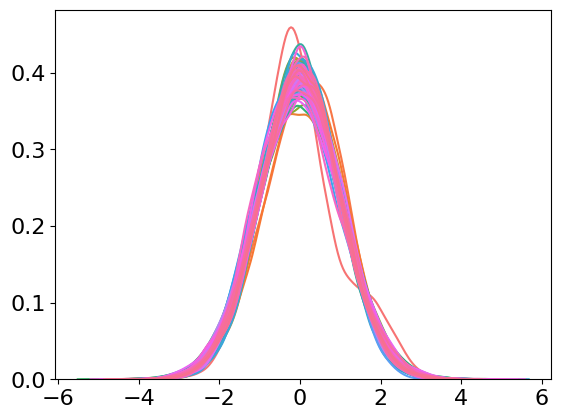

In [23]:
# without property prediction
plot_latent_kde(model=model, val_loader=val_loader)

  1%|          | 1/101 [00:00<00:14,  6.72it/s]

100%|██████████| 128/128 [00:16<00:00,  7.65it/s]


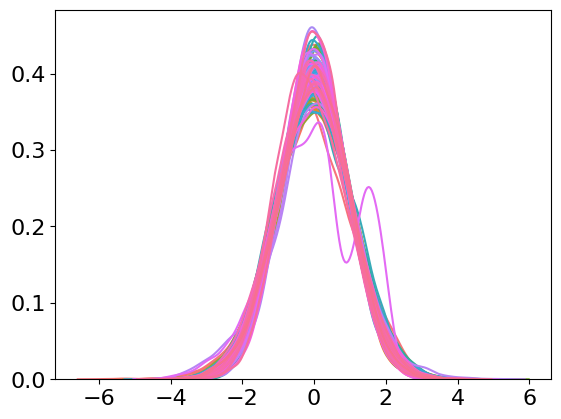

In [24]:
# with property prediction
plot_latent_kde(model_prop, val_loader)

  6%|▌         | 6/101 [00:00<00:03, 24.45it/s]

100%|██████████| 128/128 [00:16<00:00,  7.90it/s]


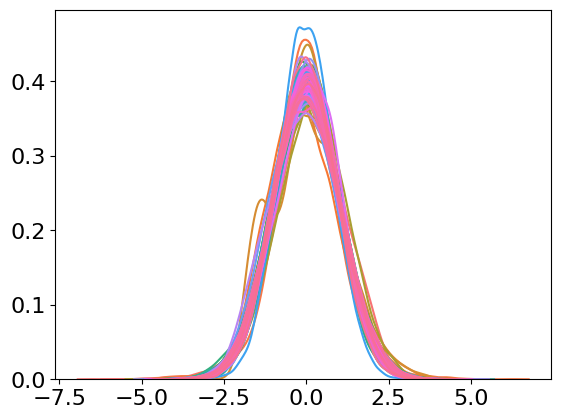

In [25]:
# with property prediction
plot_latent_kde(model_prop_split, val_loader)

### Latent PCA Plots

In [9]:
# without property prediction
def plot_latent_pca(model: GraphVAE, loader: DataLoader):
    z_list = []
    y_list = []
    for batch in tqdm(loader):
        with torch.no_grad():
            z_list.append(model.z_to_property_z(model.encode_mean(batch)))
            y_list.append(model_prop.denormalize_properties(batch.y))

    z = torch.cat(z_list, dim=0).detach().cpu().numpy()
    y = torch.cat(y_list, dim=0).detach().cpu().numpy()

    z_pca = PCA(n_components=2).fit_transform(z)
    z_pca = MinMaxScaler().fit_transform(z_pca)

    for index, property in enumerate(properties):
        scatter = plt.scatter(x= z_pca[:, 0], y=z_pca[:,1], c=y[:, index],
                    cmap= 'viridis', marker='.',
                    s=10,alpha=0.5, edgecolors='none')
        plt.colorbar(scatter, label=property.upper())
        plt.show()

  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [01:05<00:00,  1.94it/s]


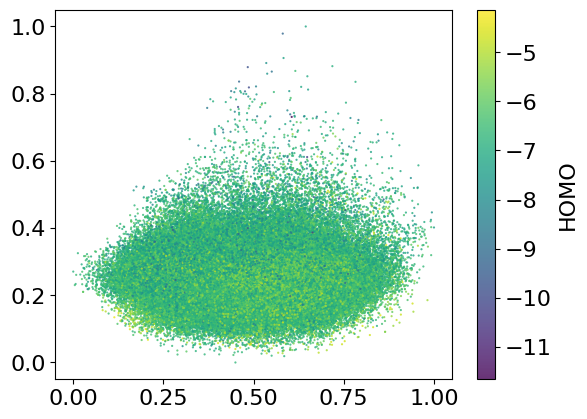

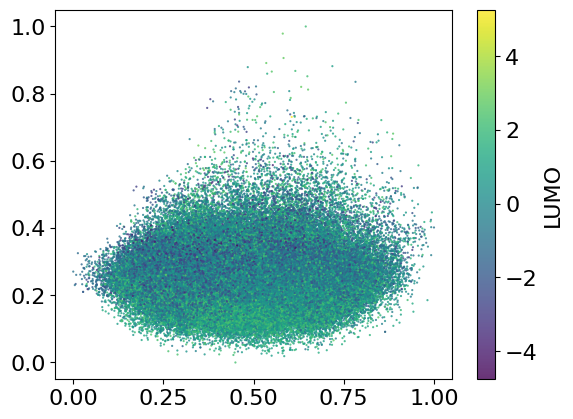

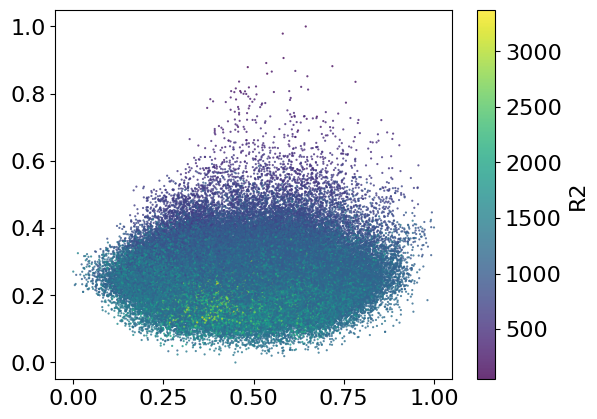

In [10]:
# model without property prediction
plot_latent_pca(model=model, loader=full_loader)

  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [00:41<00:00,  3.07it/s]


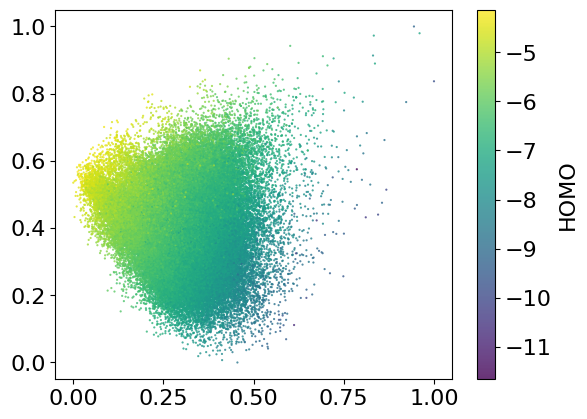

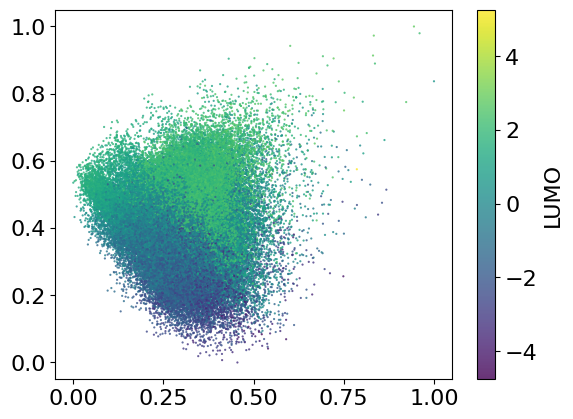

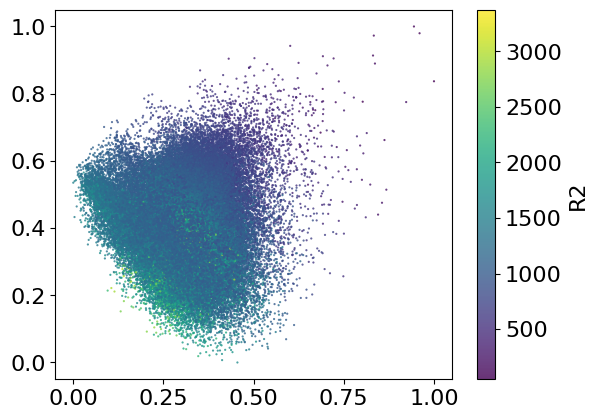

In [11]:
# model with property prediction
plot_latent_pca(model=model_prop, loader=full_loader)

  4%|▎         | 36/1001 [00:01<00:38, 24.91it/s]

100%|██████████| 1001/1001 [00:39<00:00, 25.07it/s]


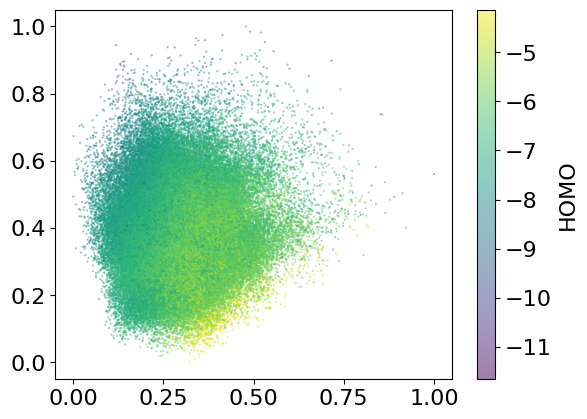

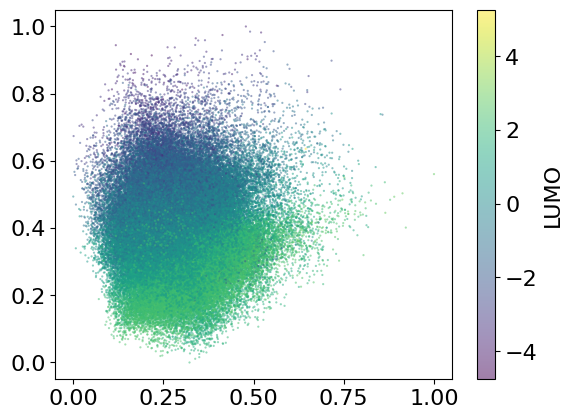

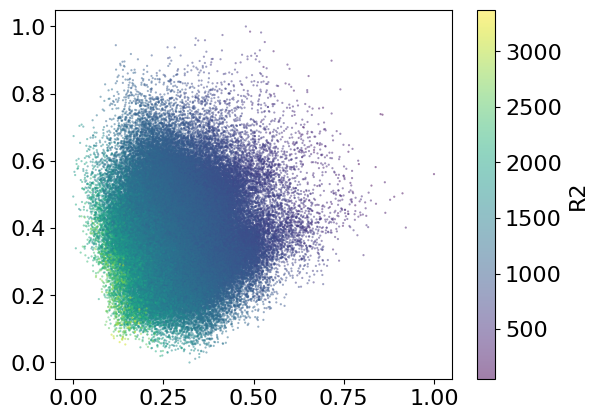

In [18]:
# model with property prediction and latent splitting
plot_latent_pca(model=model_prop_split, loader=full_loader)

### Latent Interpolation

In [6]:
def slerp(val, low, high):
    """Spherical linear interpolation."""
    low_norm = low / torch.norm(low, dim=-1, keepdim=True)
    high_norm = high / torch.norm(high, dim=-1, keepdim=True)
    
    dot_product = torch.clamp(torch.sum(low_norm * high_norm, dim=-1), -1.0, 1.0)
    omega = torch.acos(dot_product)
    so = torch.sin(omega)
    
    if torch.any(so < 1e-6):
        # linear interpolation for cases where the vectors are almost the same or opposite
        return (1.0 - val) * low + val * high
    
    return (torch.sin((1.0 - val) * omega) / so).unsqueeze(-1) * low + (torch.sin(val * omega) / so).unsqueeze(-1) * high


def plot_latent_interpolation(start_index: int, end_index: int, val_loader: DataLoader, model: GraphVAE):

    print(f"Start Index = {start_index}")
    print(f"End Index = {end_index}")

    with torch.no_grad():

        val_batch = next(iter(val_loader))

        z = model.encode_mean(val_batch)

        z_start = z[start_index].unsqueeze(0)
        z_end = z[end_index].unsqueeze(0)

        num_steps = 8
        _, axs = plt.subplots(1, num_steps, figsize=(20, 20))
        axs = axs.flatten()

        for i in range(num_steps):
            f = i / (num_steps - 1)
            z_interpolated = slerp(f, z_start, z_end)

            recon = model.decode(z_interpolated)
            
            x = (recon[0], recon[1], recon[2])

            # plot start- and endpoint encoder input molecules
            if i == 0:
                graph = val_batch[start_index]
            elif i == num_steps - 1:
                graph = val_batch[end_index]
            else:
                graph = model.output_to_graph(x=x, stochastic=False)

            is_valid = True
            if not nx.is_connected(pyg_utils.to_networkx(graph, to_undirected=True)):
                is_valid = False

            try:
                mol = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=True)
            except Exception as e:
                is_valid = False
                print(e)

            axs[i].imshow(Draw.MolToImage(mol))
            # title = "Valid" if is_valid else "Invalid"
            # axs[i].set_title(title)
            axs[i].axis("off")

    plt.tight_layout()
    plt.show()

Start Index = 971
End Index = 550


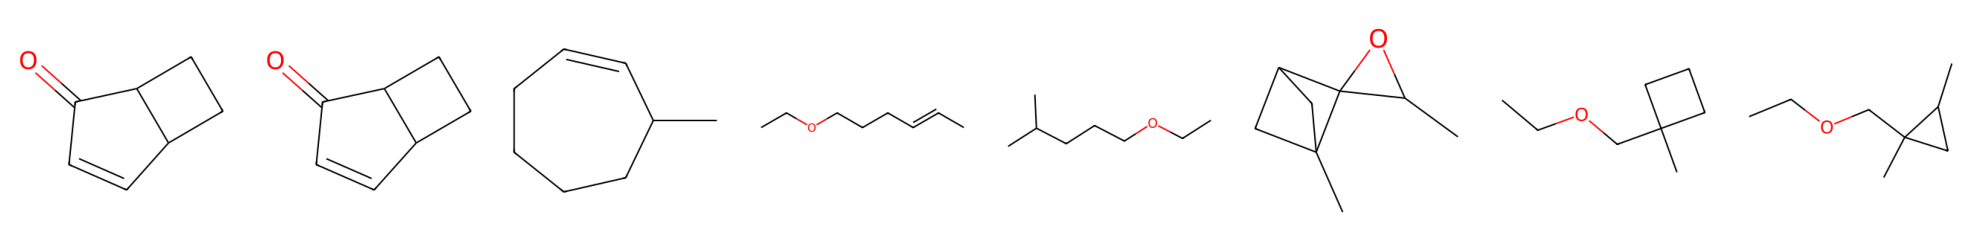

In [7]:
# fix the random seed
random.seed(12)
start_index = random.randrange(0, batch_size)
end_index = random.randrange(0, batch_size)
plot_latent_interpolation(start_index=start_index, end_index=end_index, val_loader=val_loader, model=model)

Start Index = 593
End Index = 171


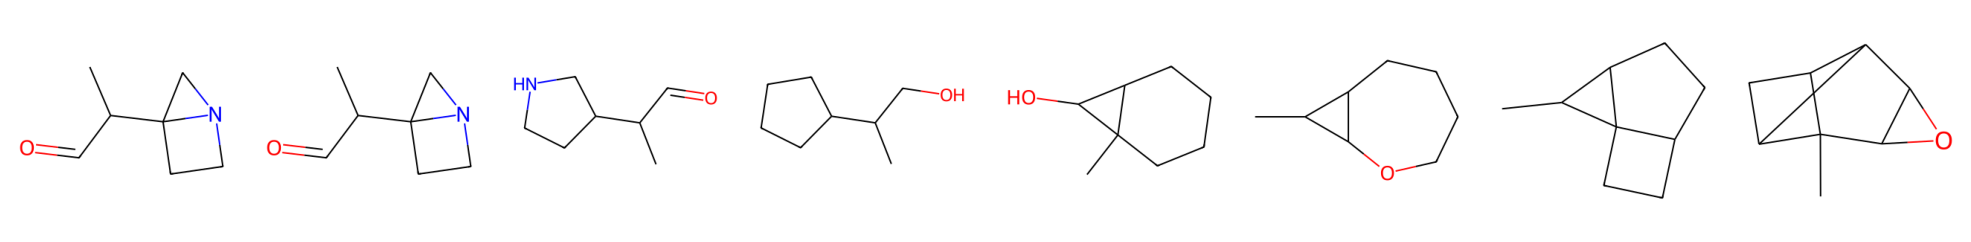

In [8]:
# fix the random seed
random.seed(23)
start_index = random.randrange(0, batch_size)
end_index = random.randrange(0, batch_size)
plot_latent_interpolation(start_index=start_index, end_index=end_index, val_loader=val_loader, model=model)

Start Index = 228
End Index = 51


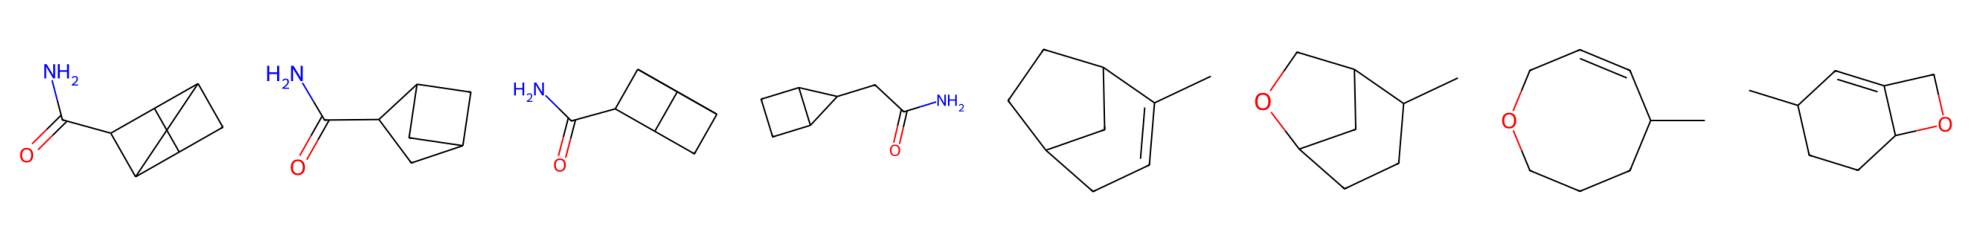

In [41]:
# fix the random seed
random.seed(42)
start_index = random.randrange(0, batch_size)
end_index = random.randrange(0, batch_size)
plot_latent_interpolation(start_index=start_index, end_index=end_index, val_loader=val_loader, model=model)

Start Index = 556
End Index = 855


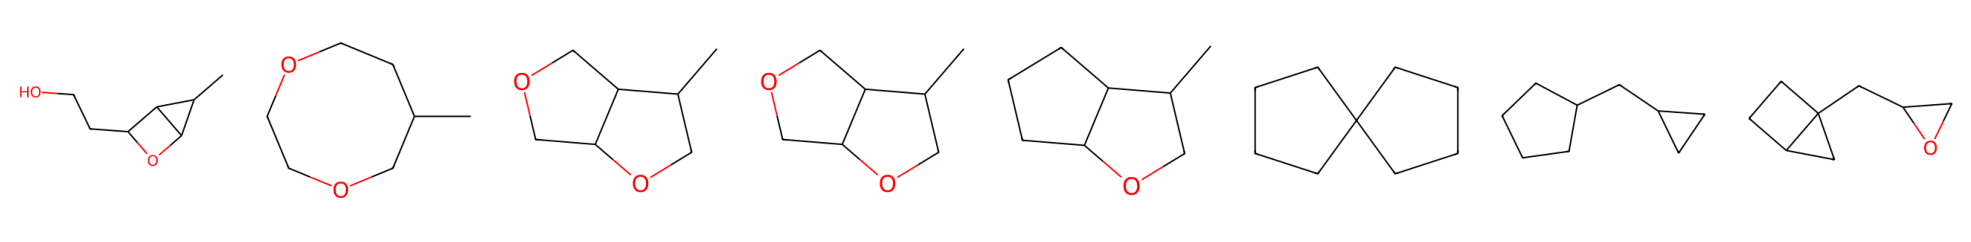

In [42]:
# fix the random seed
random.seed(45)
start_index = random.randrange(0, batch_size)
end_index = random.randrange(0, batch_size)
plot_latent_interpolation(start_index=start_index, end_index=end_index, val_loader=val_loader, model=model)

Start Index = 297
End Index = 896


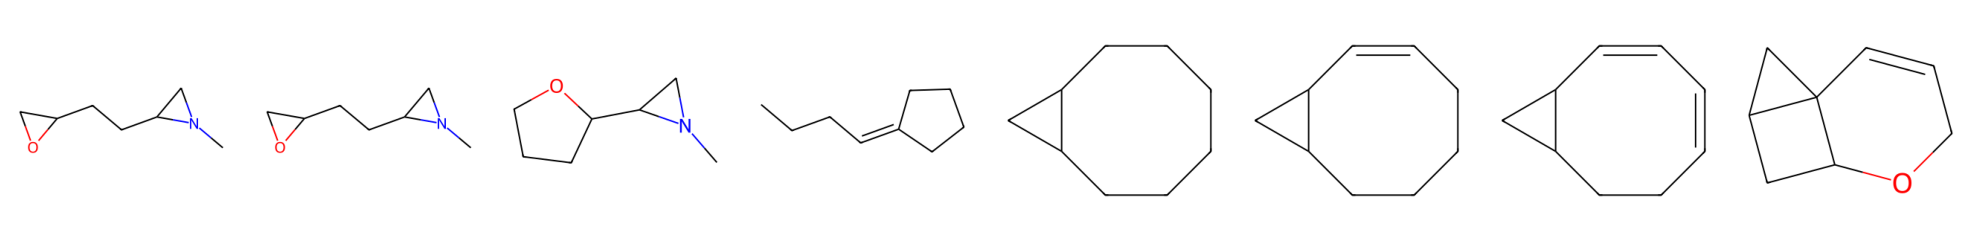

In [43]:
# fix the random seed
random.seed(79)
start_index = random.randrange(0, batch_size)
end_index = random.randrange(0, batch_size)
plot_latent_interpolation(start_index=start_index, end_index=end_index, val_loader=val_loader, model=model)

### Latent Neighborhood Sampling

In [36]:
def plot_latent_neighbors(model: GraphVAE, val_loader: DataLoader, mol_index: int):
    """ Sample points in the latent neighborhood of the validation molecules specified by mol_index and plot. """

    val_batch = next(iter(val_loader))
        
    # plot the input molecule
    print("Input Molecule")
    input_mol = graph_to_mol(data=val_batch[mol_index], includes_h=include_hydrogen, validate=False)
    plt.imshow(Draw.MolToImage(input_mol))
    plt.axis("off")
    plt.show()

    # encode the input molecule
    z = model.encode_mean(val_batch)[mol_index].unsqueeze(0)

    # sample points in the latent space at increasing distances from the encoded input molecule
    decode_count = 32
    decoded_mols = dict()
    for i in tqdm(range(decode_count)):
        with torch.no_grad():            
            noise_vec = torch.randn_like(z, device=device)
            noise_vec_norm = noise_vec / torch.linalg.vector_norm(noise_vec)

            noise_scale = 24 * torch.rand(size=(1,), device=device)
            z_current = z + noise_vec_norm * noise_scale
            distance = torch.dist(z, z_current).item()
            val_recon = model.decode(z_current)
            
            x = (val_recon[0], val_recon[1], val_recon[2])
            recon_graph = model.output_to_graph(x=x, stochastic=False)

            # discard invalid molecules
            if not nx.is_connected(pyg_utils.to_networkx(recon_graph, to_undirected=True)):
                continue
            try:
                recon_mol = graph_to_mol(data=recon_graph, includes_h=include_hydrogen, validate=True)
            except:
                continue

            smiles = Chem.MolToSmiles(recon_mol)
            decoded_mols[smiles] = (recon_mol, distance)

    # sort the molecules by latent distance to the input molecule
    mol_list = []
    distance_list = []
    for _, (mol, distance) in decoded_mols.items():
        mol_list.append(mol)
        distance_list.append(distance)

    df = pd.DataFrame({"mol": mol_list, "distance": distance_list})
    df.sort_values(by="distance", ascending=True, inplace=True)
    df = df.head(18)

    num_cols = 6
    num_rows = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
    fig.tight_layout(pad=3.0)
    axes = axes.flatten("F")

    for i, (index, row) in enumerate(df.iterrows()):
        mol = row["mol"]
        distance = row["distance"]
        ax = axes[i]
        ax.imshow(Draw.MolToImage(mol))
        ax.set_title(f"{distance:.2f}", fontsize=32)
        ax.axis("off")

    # # If the number of molecules is not a perfect fill for the subplot grid, hide the extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.show()

Input Molecule


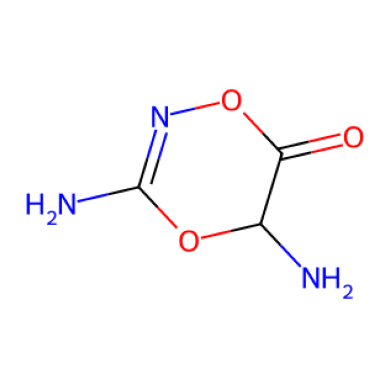

100%|██████████| 32/32 [00:00<00:00, 400.05it/s]


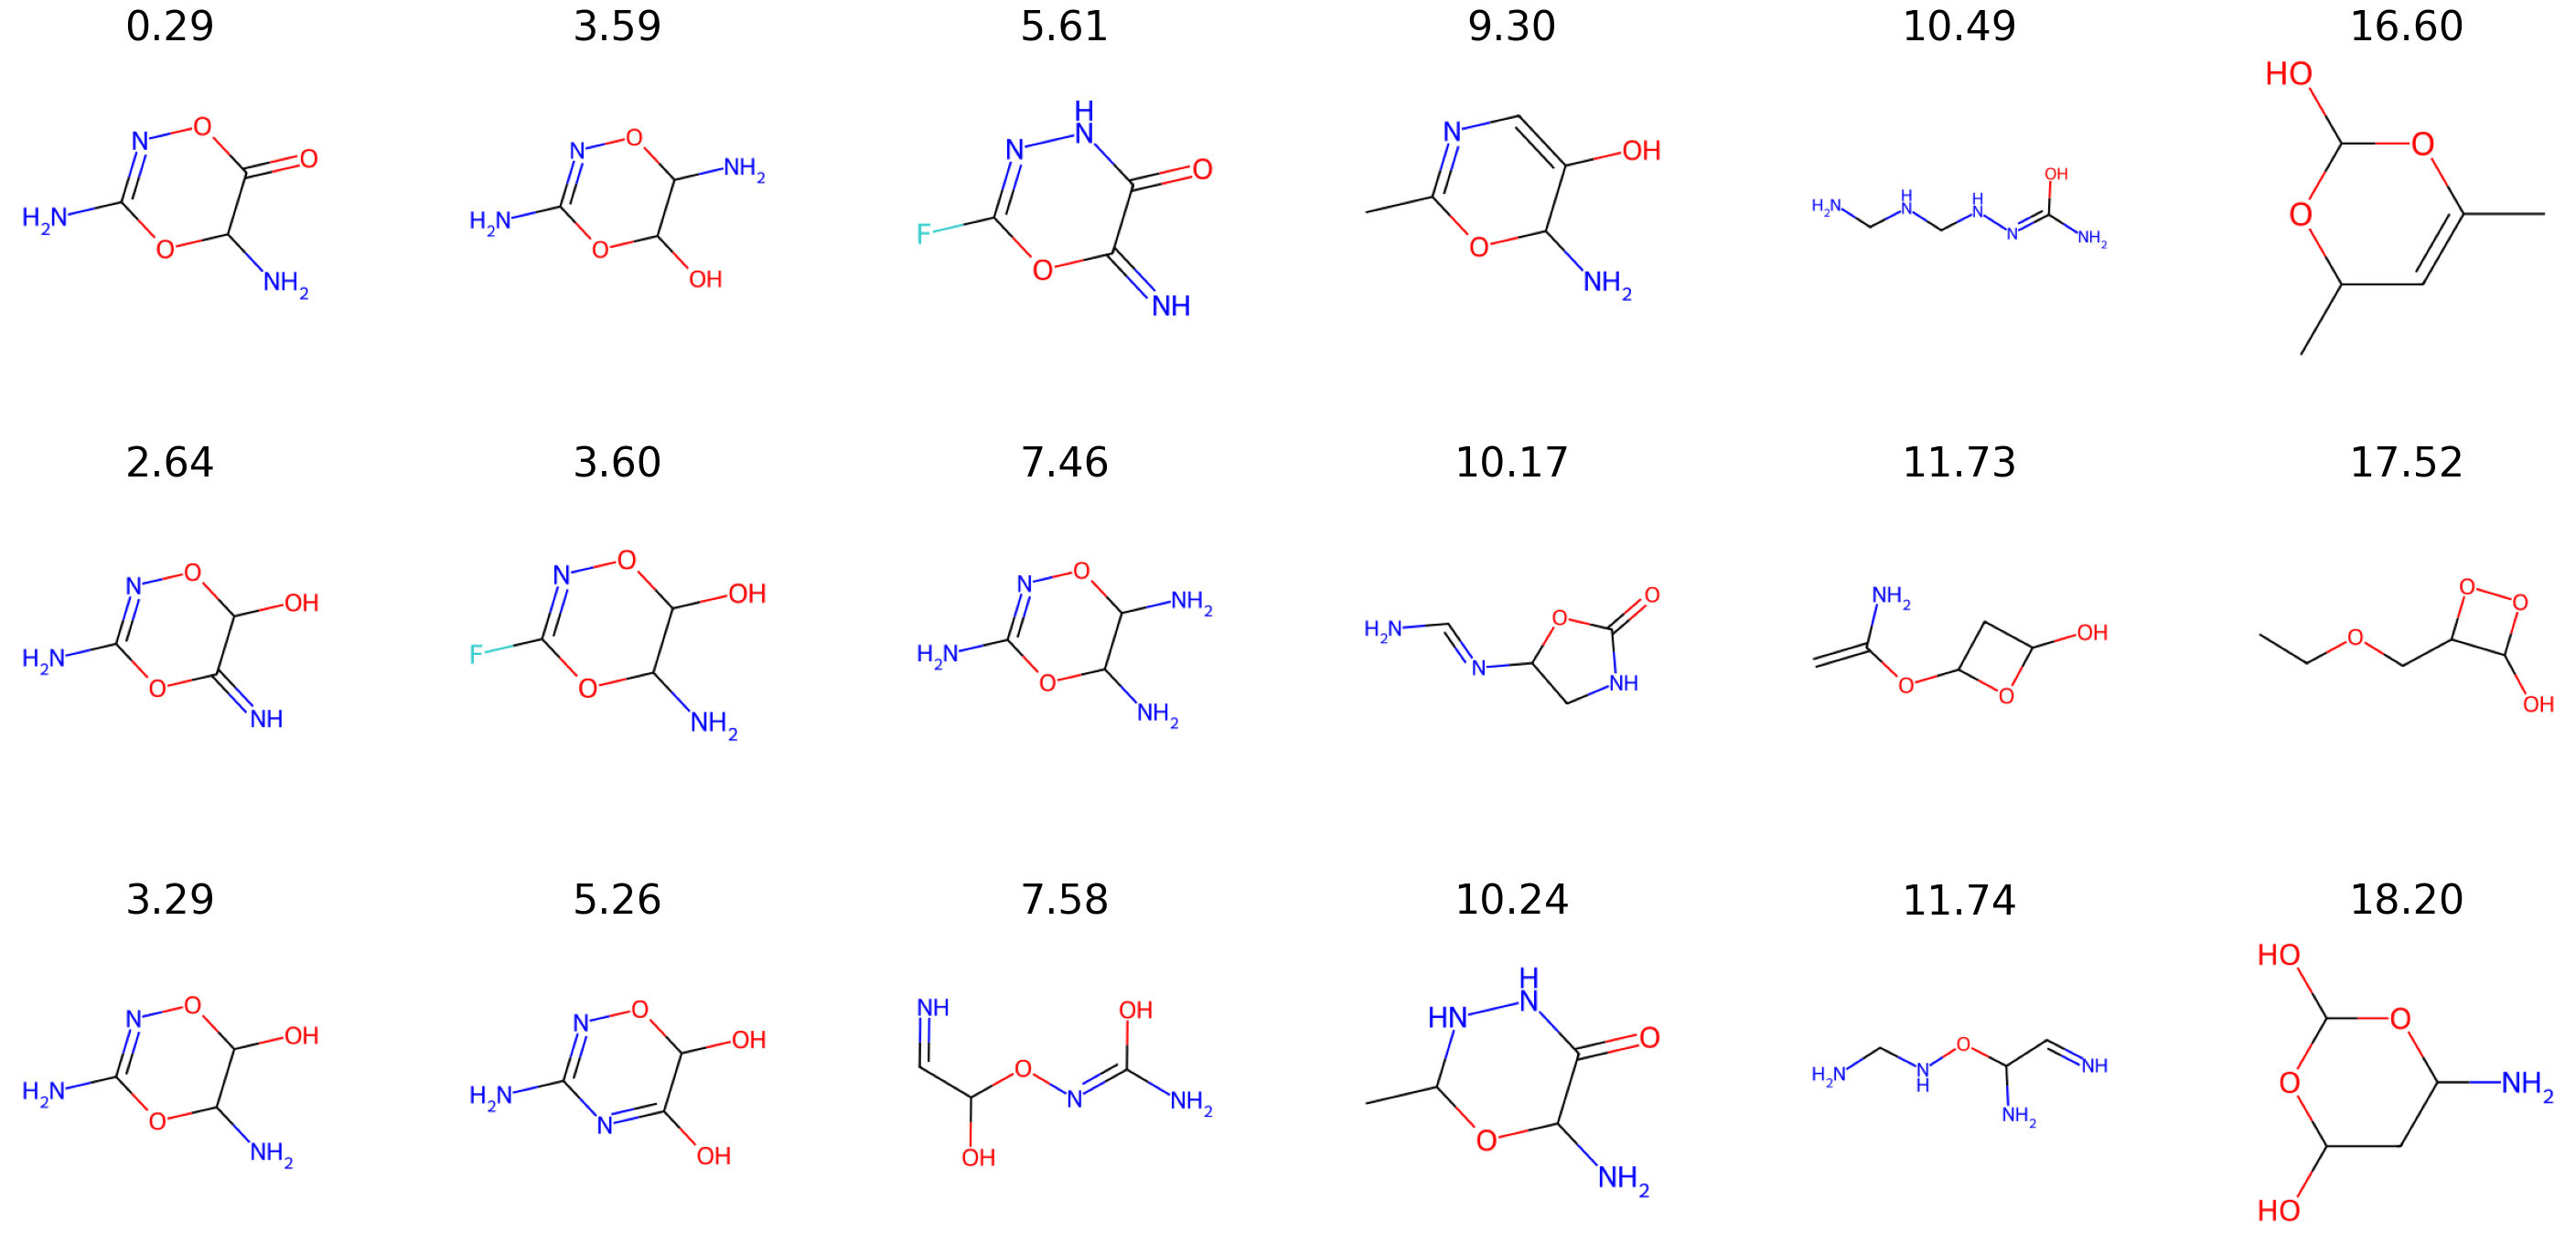

In [37]:
plot_latent_neighbors(model=model, val_loader=val_loader, mol_index=834)

Input Molecule


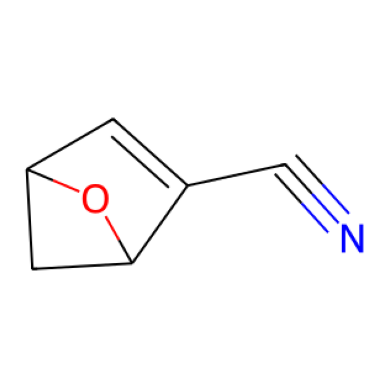

100%|██████████| 32/32 [00:00<00:00, 375.30it/s]


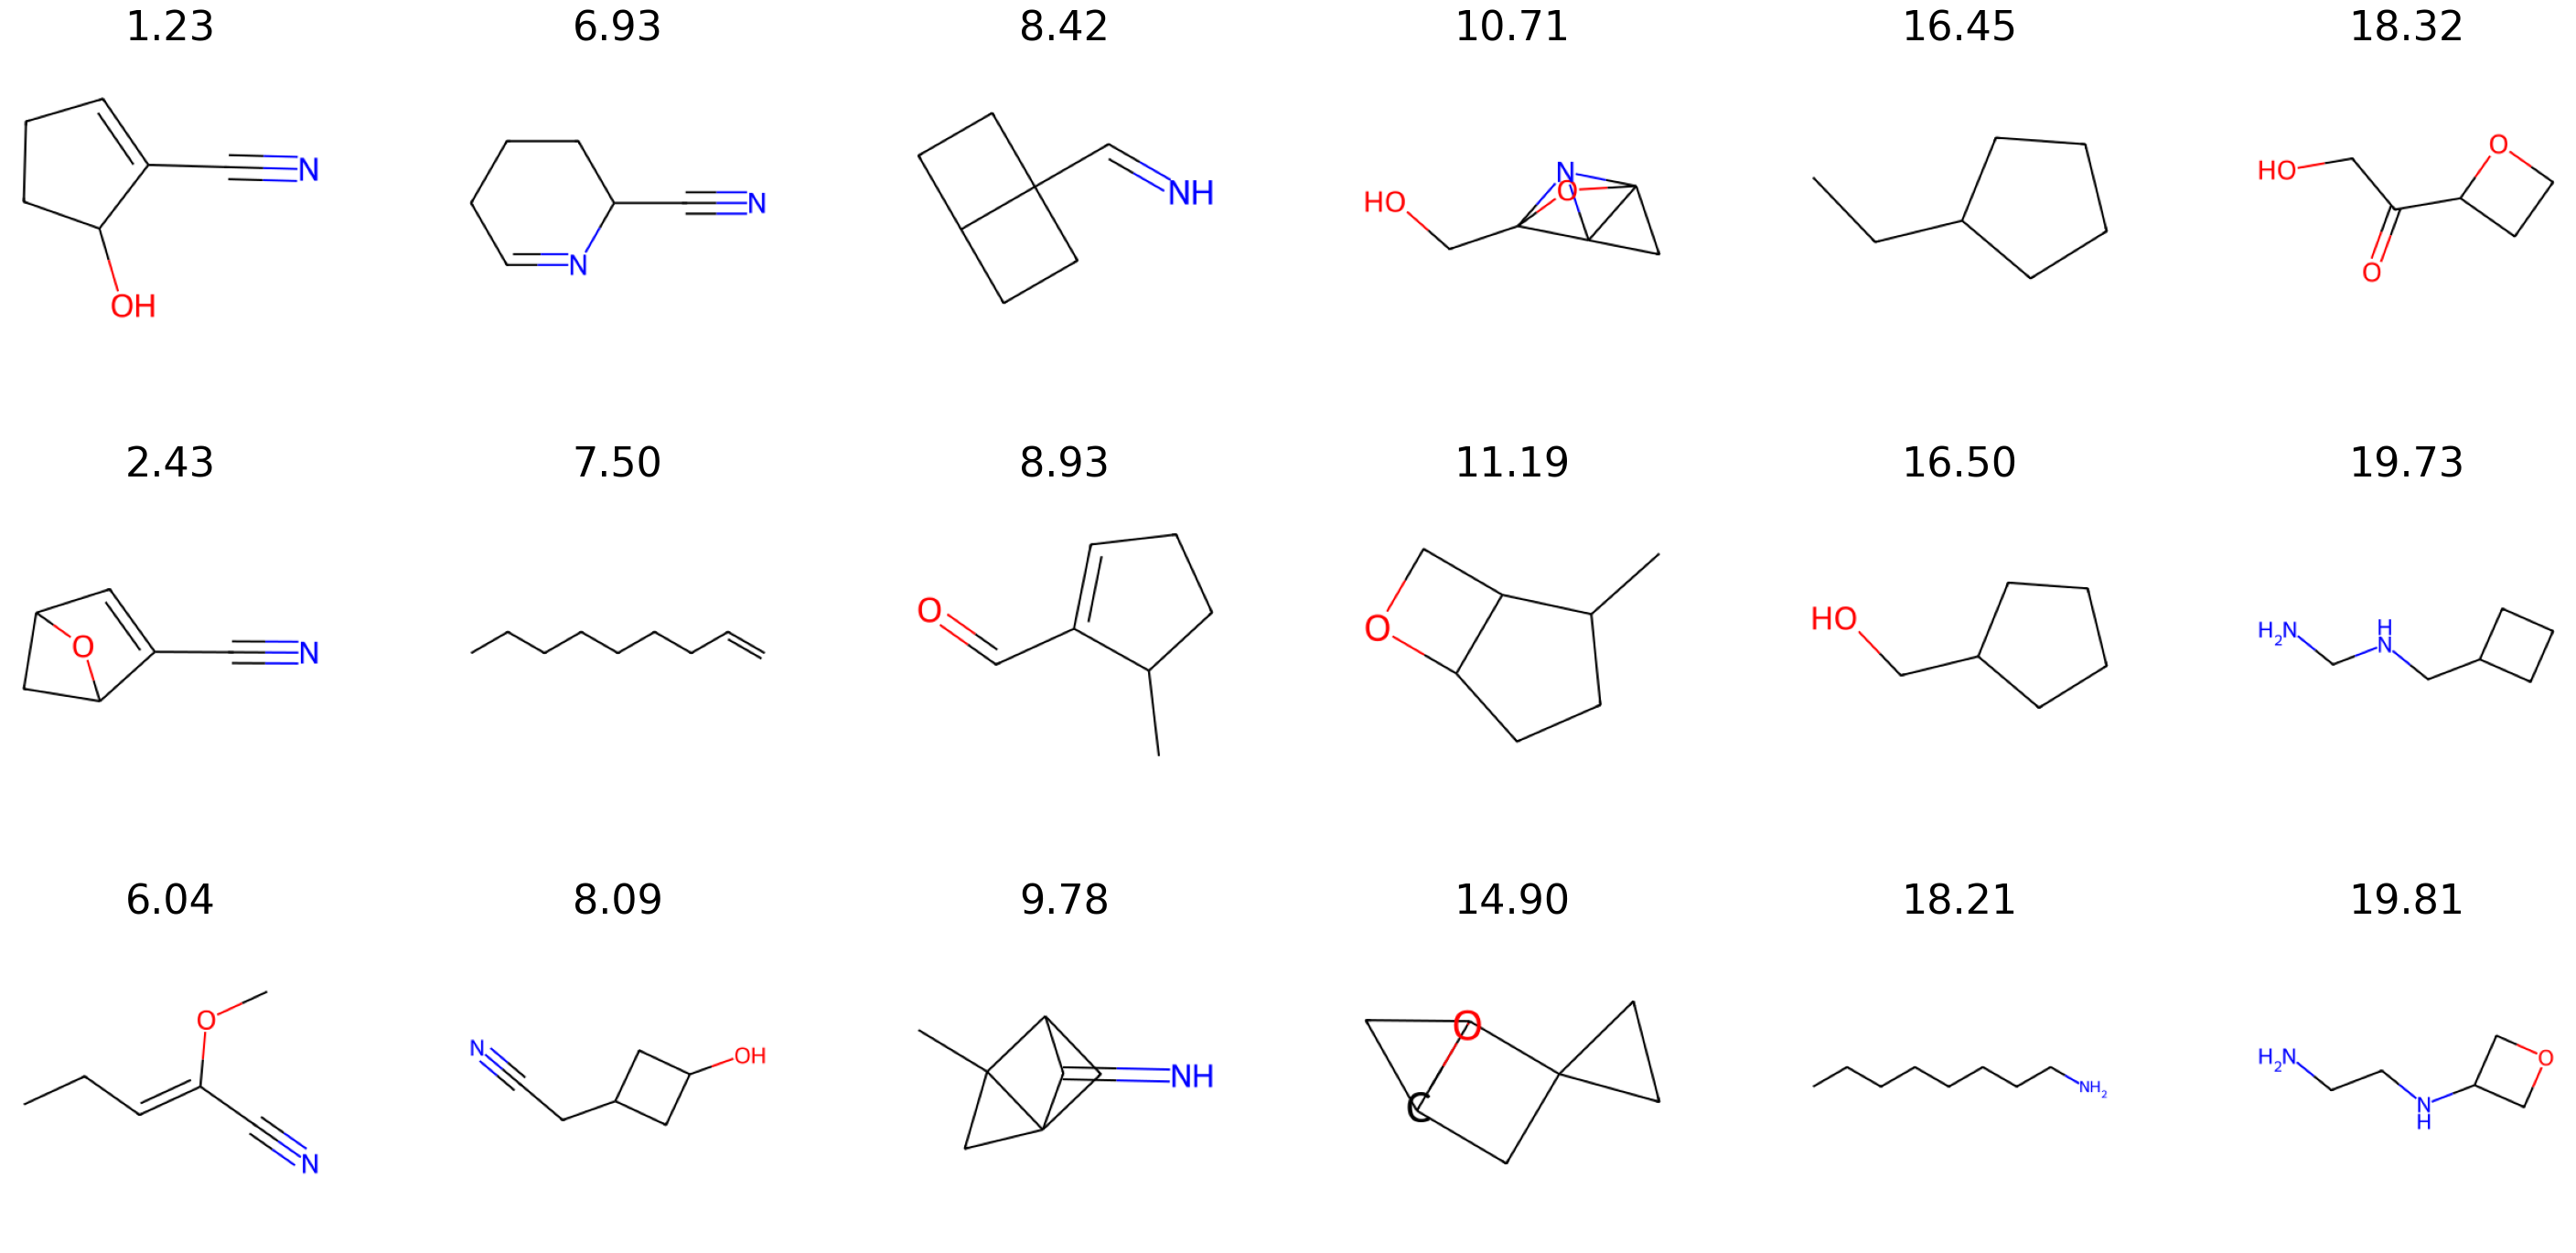

In [51]:
plot_latent_neighbors(model=model, val_loader=val_loader, mol_index=931)

Input Molecule


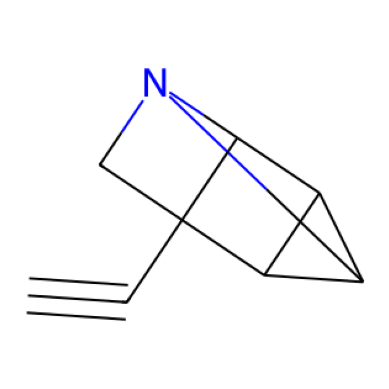

100%|██████████| 32/32 [00:00<00:00, 307.27it/s]


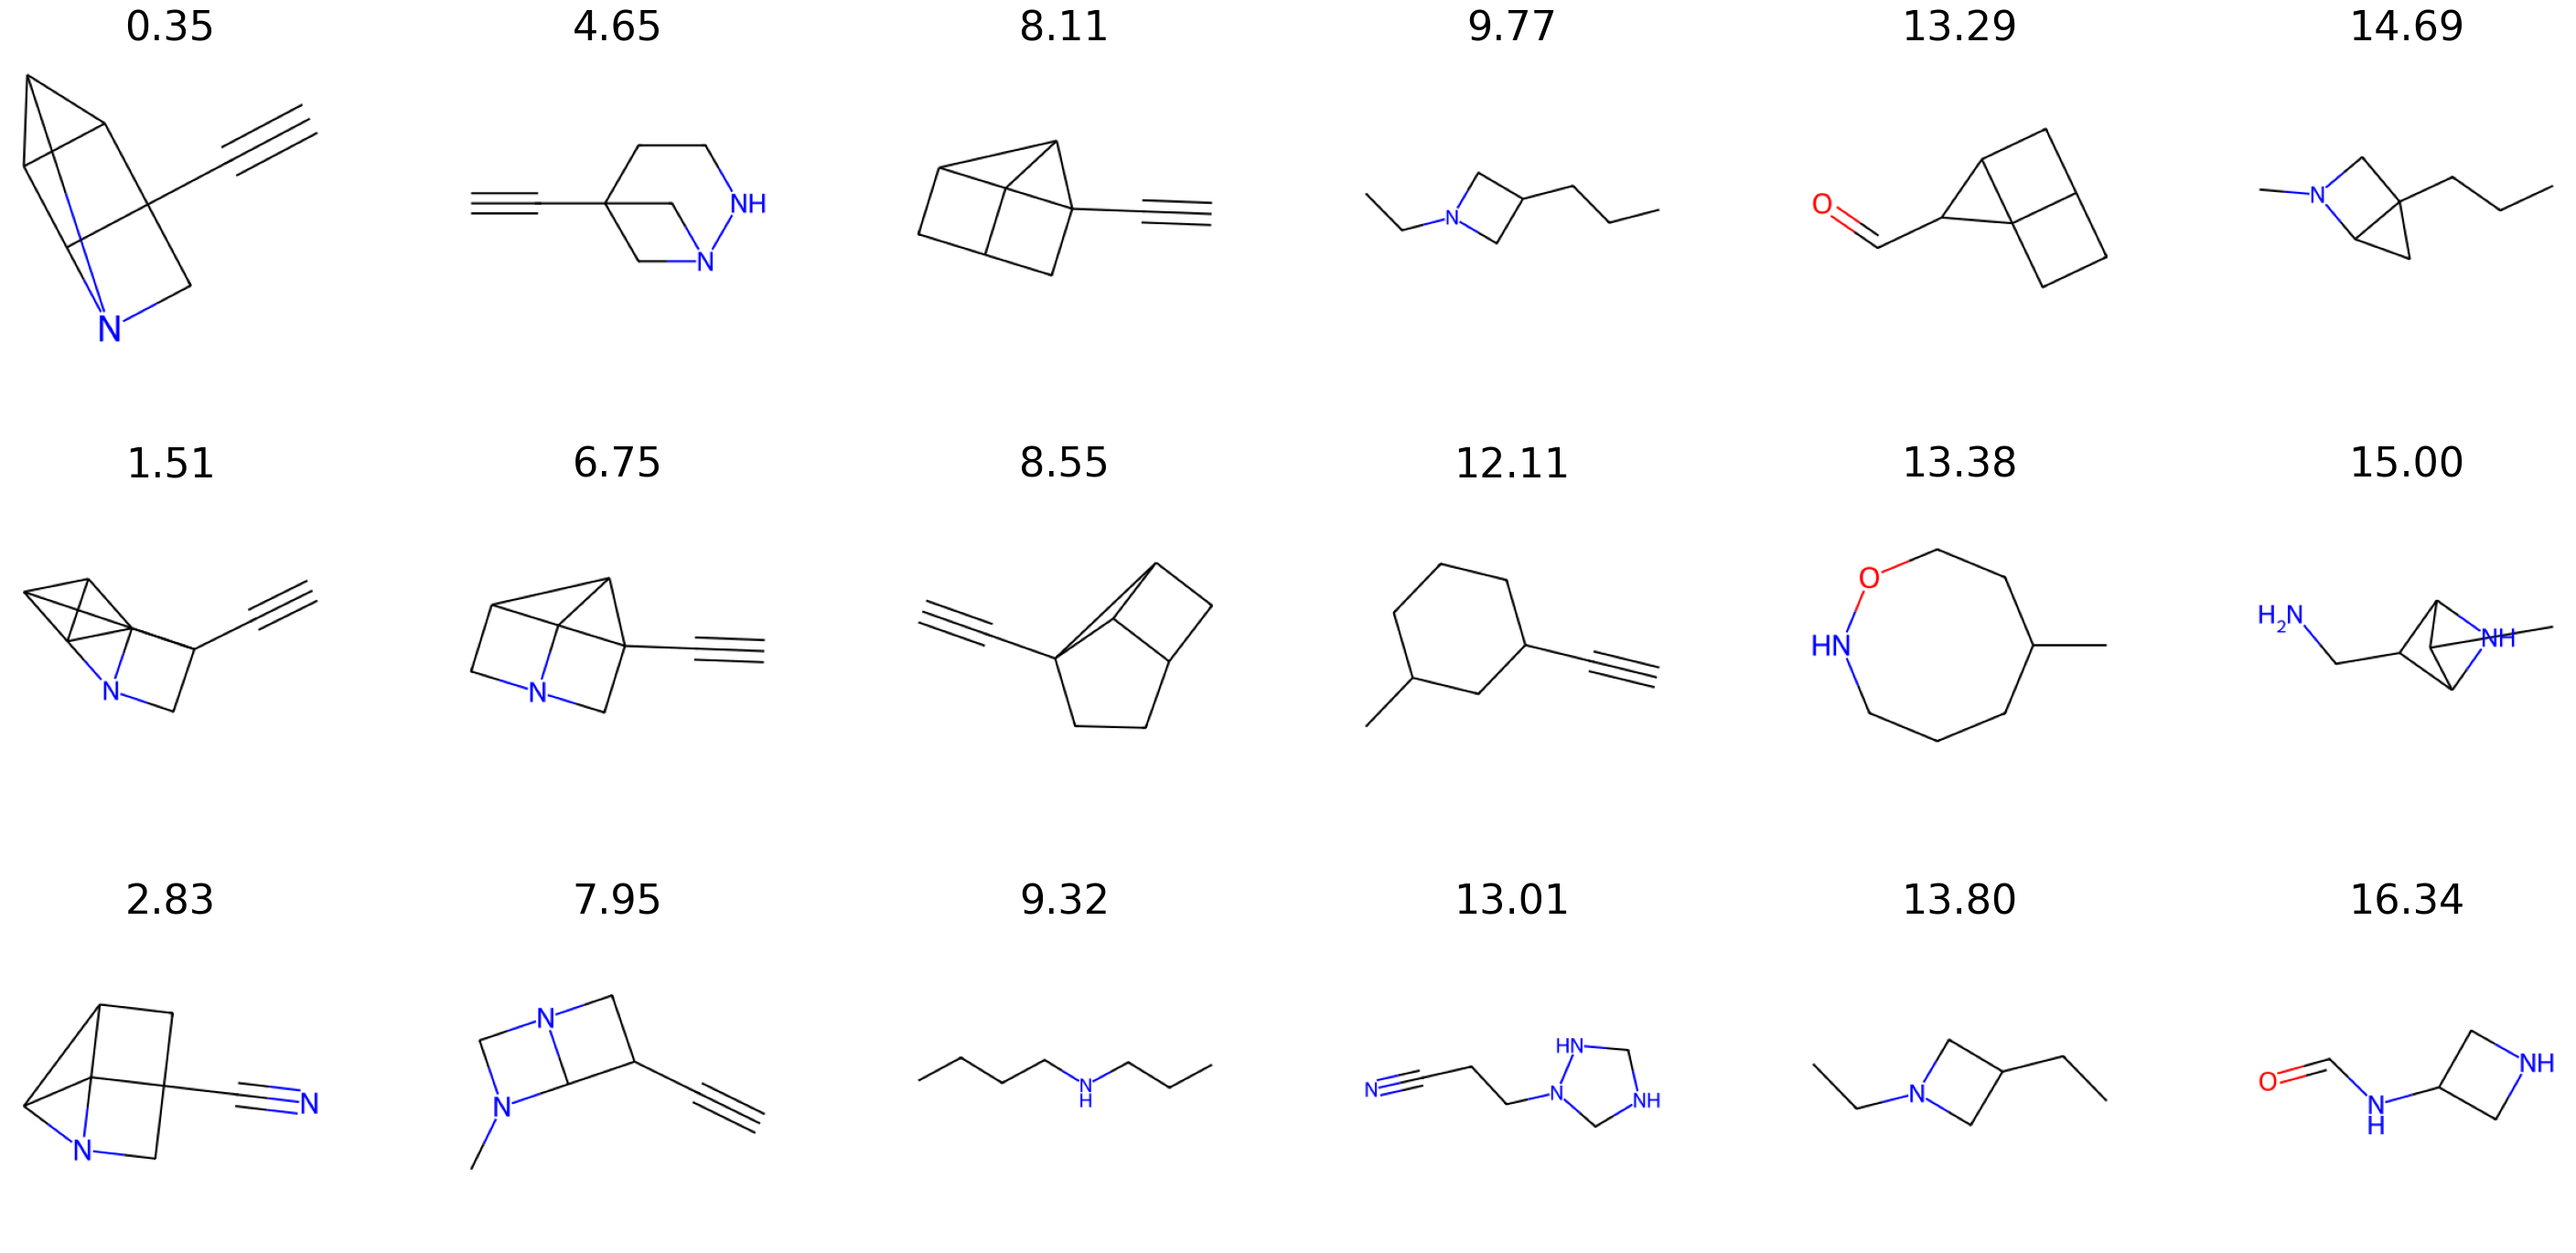

In [52]:
plot_latent_neighbors(model=model, val_loader=val_loader, mol_index=123)

### Decoding Distribution

In [36]:
def visualize_decoding_distribution(model: GraphVAE, val_loader: DataLoader, mol_index: int):
    """
    Encode a single molecule from the validation set and visualize the decoding distribution.

    Plots the following:
        - Input molecule
        - Decoded molecules ordered by frequency
        - A histogram visualizing the frequency along with the latent euclidean distance between the input molecule and the re-encoded molecule.
    """
    val_batch = next(iter(val_loader))

    # plot the input molecule
    print("Input Molecule")
    input_mol = graph_to_mol(data=val_batch[mol_index], includes_h=include_hydrogen, validate=False)
    plt.imshow(Draw.MolToImage(input_mol))
    plt.axis("off")
    plt.show()

    # encode the input molecule
    z = model.encode_mean(val_batch)[mol_index].unsqueeze(0)
    model_ouput = model.decode(z)
    x = (model_ouput[0], model_ouput[1], model_ouput[2])

    decoded_smiles_to_mol_count_map = dict()
    decode_attempts = 512
    for _ in tqdm(range(decode_attempts)):
        graph = model.output_to_graph(x=x, stochastic=True)

        # discard invalid molecules
        if not nx.is_connected(pyg_utils.to_networkx(graph, to_undirected=True)):
            continue
        try:
            molecule = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=True)
        except:
            continue

        smiles = Chem.MolToSmiles(molecule)

        if smiles not in decoded_smiles_to_mol_count_map:
            # encode generated graph and compute distance to original z
            z_reencoded = model.encode_mean(graph)
            distance = torch.norm(z - z_reencoded).item()

            decoded_smiles_to_mol_count_map[smiles] = (molecule, 1, distance, graph)
        else:
            mol, count, distance, graph = decoded_smiles_to_mol_count_map[smiles]
            count += 1
            decoded_smiles_to_mol_count_map[smiles] = (mol, count, distance, graph)

    mol_list = []
    count_list = []
    distance_list = []
    graph_list = []
    for _, (mol, count, distance, graph) in decoded_smiles_to_mol_count_map.items():
        mol_list.append(mol)
        count_list.append(count)
        distance_list.append(distance)
        graph_list.append(graph)

    df = pd.DataFrame({"mol": mol_list, "count": count_list, "distance": distance_list, "graph": graph_list})
    df.sort_values(by="count", ascending=False, inplace=True)
    df = df.head(6).reset_index()
    df["Frequency"] = df["count"] / decode_attempts

    num_cols = len(df)
    fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * 5, 5))
    fig.tight_layout(pad=3.0)
    axes = axes.flatten("F")

    # plot the decoded molecules
    for i, (_, row) in enumerate(df.iterrows()):
        mol = row["mol"]
        ax = axes[i]
        ax.imshow(Draw.MolToImage(mol))
        ax.axis("off")
    plt.show()

    # plot the histogram 
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    colors = sns.color_palette("husl", len(df))
    bars = ax1.bar(range(len(df)), df["Frequency"], color=colors)
    ax1.set_ylabel("Normalized Frequency")
    ax2.set_ylabel("z-Distance")

    for bar, distance in zip(bars, df["distance"]):
        ax2.hlines(distance, bar.get_x(), bar.get_x() + bar.get_width(), colors='black', linewidth=2)
        rounded_distance = round(distance, 2)
        ax2.annotate(str(rounded_distance),
                    (bar.get_x() + bar.get_width()/2, distance),
                    textcoords="offset points",
                    xytext=(0,0.1), 
                    ha='center',
                    va='bottom',
                    fontsize=16,
                    color='black')

    plt.xticks(ticks=[])
    plt.show()

Input Molecule


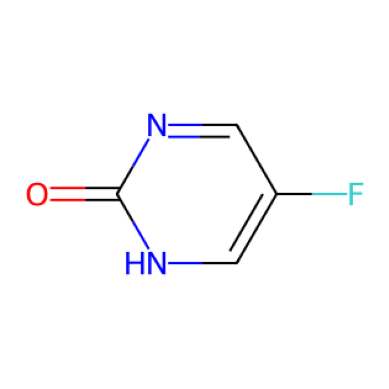

100%|██████████| 512/512 [00:01<00:00, 332.53it/s]


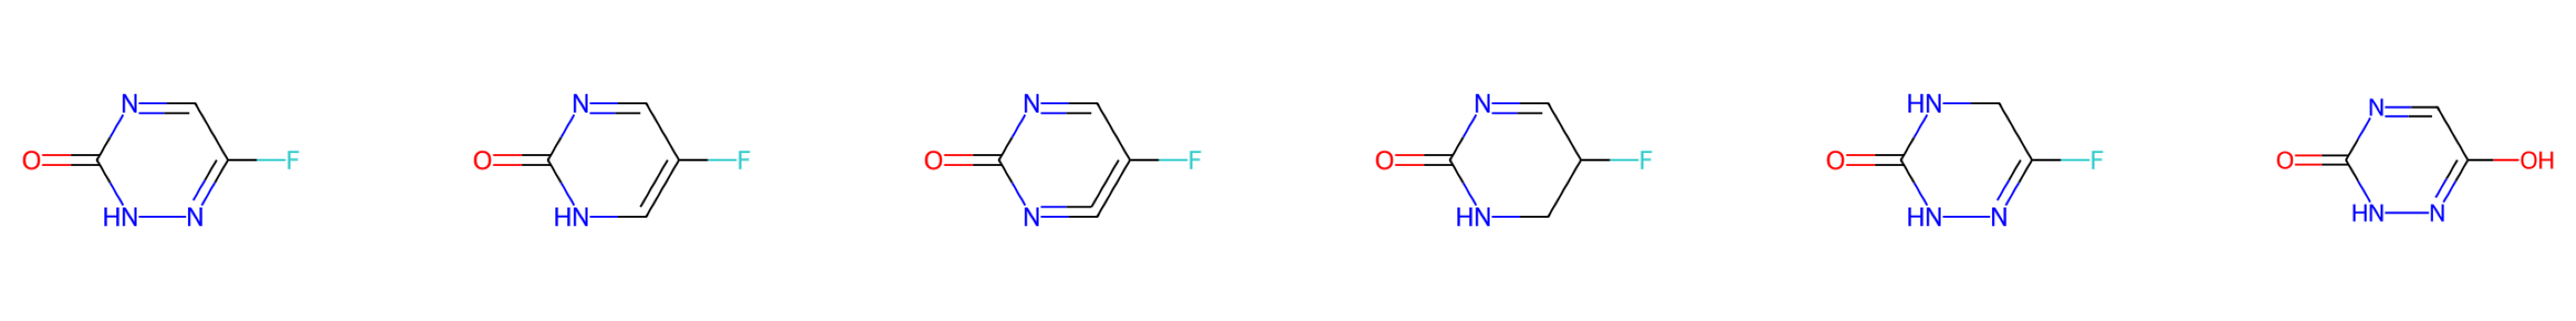

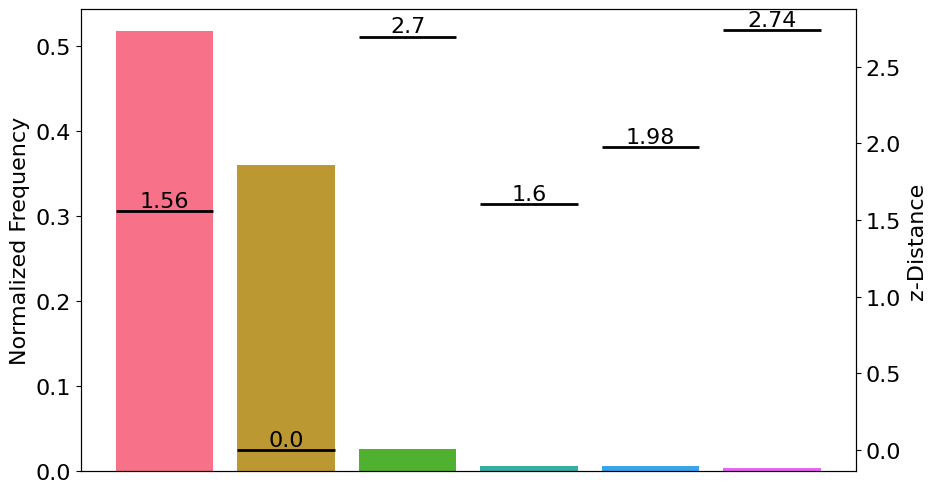

In [40]:
mol_index = 16
visualize_decoding_distribution(model=model, val_loader=val_loader, mol_index=mol_index)

Input Molecule


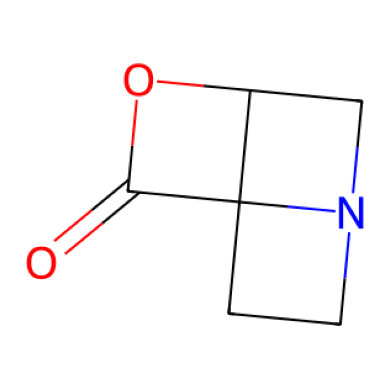

100%|██████████| 512/512 [00:01<00:00, 300.97it/s]


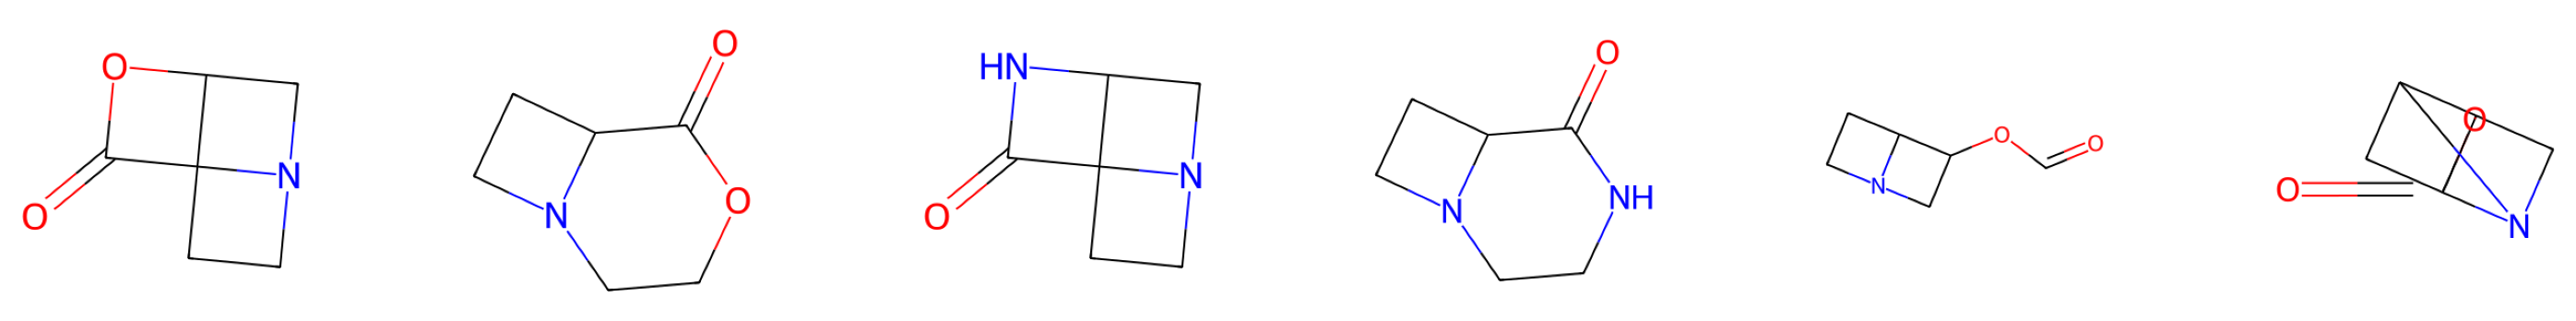

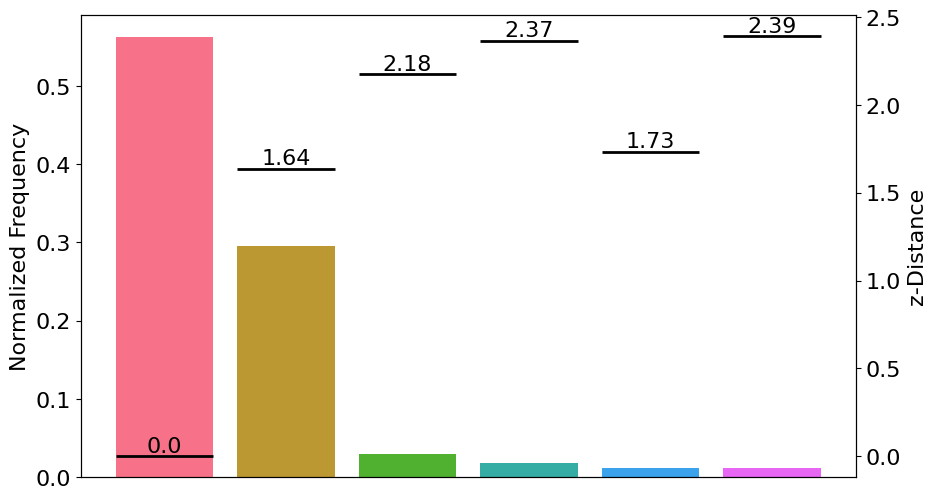

In [41]:
mol_index = 128
visualize_decoding_distribution(model=model, val_loader=val_loader, mol_index=mol_index)

Input Molecule


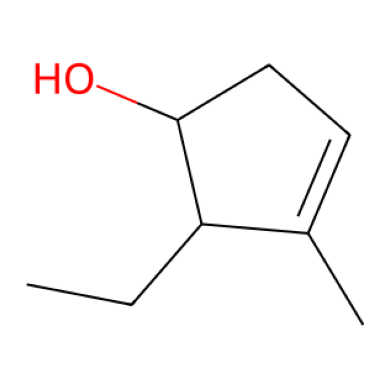

100%|██████████| 512/512 [00:01<00:00, 314.82it/s]


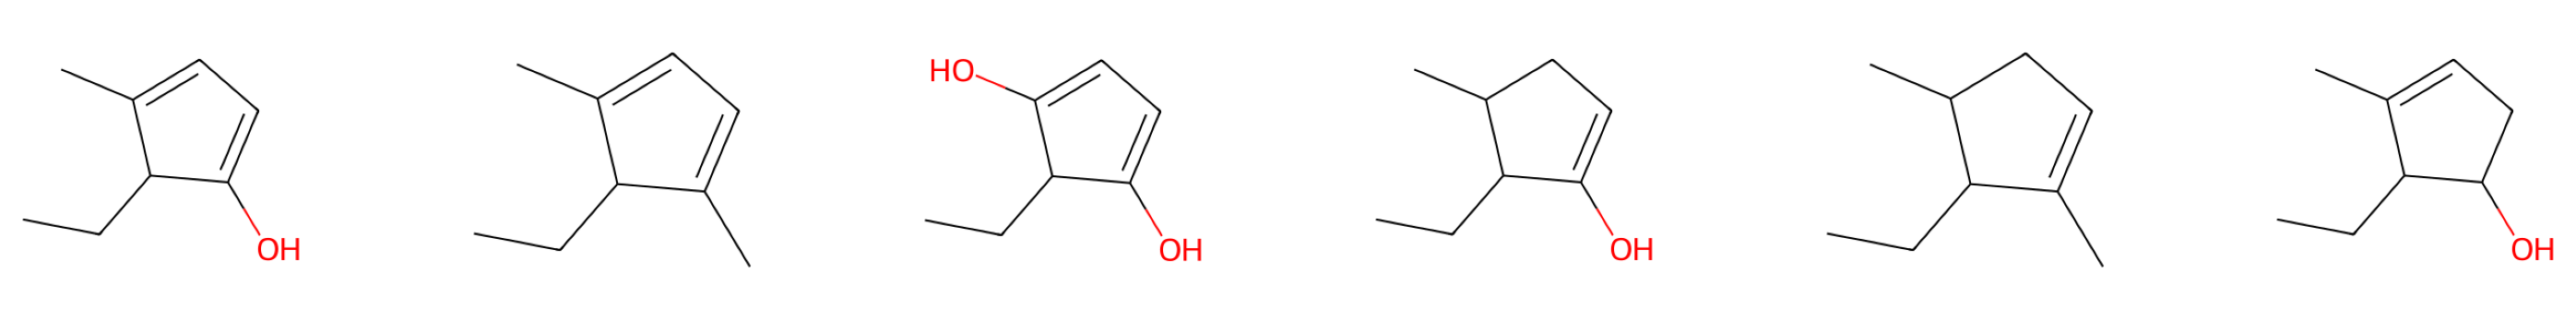

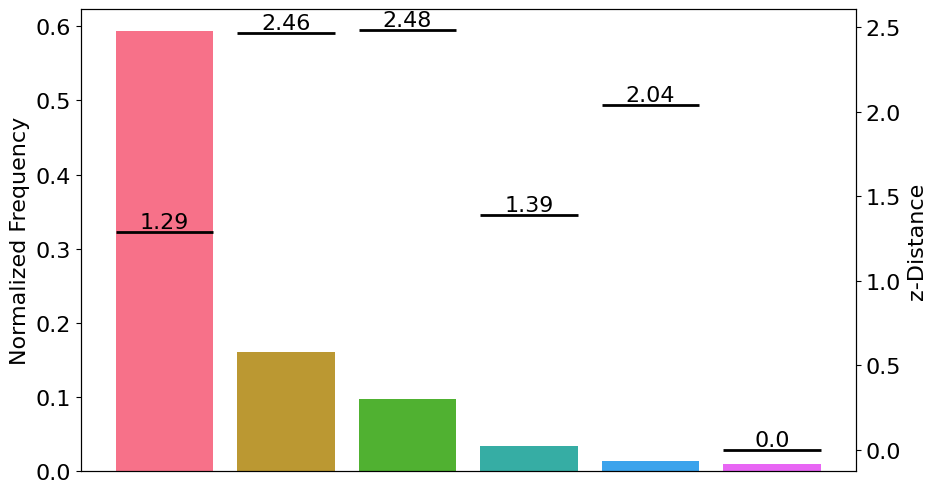

In [42]:
mol_index = 300
visualize_decoding_distribution(model=model, val_loader=val_loader, mol_index=mol_index)